# Probability Distributions and Cluster Detection

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 2 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

© 2025 Yuan-Sen Ting. All rights reserved. This tutorial is provided for educational purposes. Redistribution or reproduction requires explicit permission from the author.

## Introduction

In our exploration of Bayesian inference, we've established the theoretical foundations for probabilistic reasoning and examined how prior knowledge combines with observational data to form posterior beliefs. Now we turn our attention to a practical application that showcases these concepts in action: the detection of stellar clusters through statistical analysis of spatial point patterns.

Stars in our Galaxy generally follow a smooth distribution dictated by the gravitational potential and formation history of the Milky Way. Against this background, stellar clusters manifest as local overdensities—regions where the stellar density significantly exceeds expectations. This presents an ideal setting to explore how probability theory allows us to quantify deviations from random expectations and identify physically meaningful structures.

The detection of such overdensities connects directly to fundamental questions in astrophysics. Consider the search for intermediate-mass black holes (IMBHs) in the Milky Way halo. Theory predicts that IMBHs should retain bound stellar clusters, creating detectable overdensities in the stellar distribution. By quantifying the statistical significance of observed stellar counts relative to background expectations, we can identify candidate clusters or establish meaningful upper limits on the IMBH population when no significant overdensities are found.

This statistical framework extends beyond stellar astronomy. The same principles apply to detecting galaxy clusters in large-scale structure surveys, identifying excess high-energy particle events that could signal dark matter annihilation, or finding exoplanet transit events in time-series photometry. In each case, we seek to distinguish genuine physical structures from random fluctuations in the background distribution.

The power of this approach lies in its quantitative nature. Rather than relying on visual inspection—which becomes increasingly unreliable in high-dimensional spaces—we construct rigorous statistical tests that assign precise significance levels to potential detections. This allows us to make objective statements about the presence or absence of clusters, complete with well-defined confidence intervals and false-positive rates.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Comfort with NumPy arrays, matplotlib visualization, and basic scipy functionality
- **Probability Theory**: Understanding of probability distributions, particularly discrete distributions and their properties
- **Statistical Concepts**: Basic knowledge of random variables, expectation values, and independence

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Statistical Modeling**: Constructing probabilistic models for astronomical point processes using appropriate distributions
- **Parameter Estimation**: Implementing maximum likelihood estimation to characterize observed distributions
- **Hypothesis Testing**: Building statistical tests to distinguish genuine overdensities from random fluctuations
- **Spatial Analysis**: Applying probability theory to two-dimensional point patterns, accounting for edge effects and spatial correlations
- **Information Theory**: Using mutual information to quantify statistical dependencies between spatial regions

## Computational Setup

We begin by importing the necessary libraries and configuring our computational environment for optimal visualization:



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import seaborn as sns

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Modeling the Stellar Background Field

In developing our statistical framework for cluster detection, we begin with the simplest case: a uniform random distribution of points in a two-dimensional field. This idealization serves as our null hypothesis—the expected distribution in the absence of clusters. We model this as a spatial Poisson process, where the number of points in any region follows the Poisson distribution we explored in Chapter 2.

This model embodies several key assumptions:
1. **Spatial homogeneity**: The background density $\rho$ remains constant across the field
2. **Spatial stationarity**: Statistical properties are invariant under translation
3. **Complete spatial randomness**: The presence of a star at one location does not influence the probability of finding stars at other locations

These assumptions allow us to leverage the mathematical simplicity of the Poisson process. For a region of area $A$ with uniform density $\rho$, the probability of observing exactly $k$ stars follows:

$$P(N = k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

where $\lambda = \rho A$ represents the expected number of stars in that region.

While this idealized model provides a tractable starting point, real astronomical applications require careful consideration of systematic effects. The stellar density field $\rho(l,b)$ varies significantly with Galactic coordinates due to the exponential structure of the Galactic disk, the presence of spiral arms, differential extinction, and observational selection effects. Nevertheless, the uniform model serves as an essential foundation for developing our statistical methodology, and the techniques we develop here can be extended to handle more realistic density variations through appropriate coordinate transformations or local density estimates.

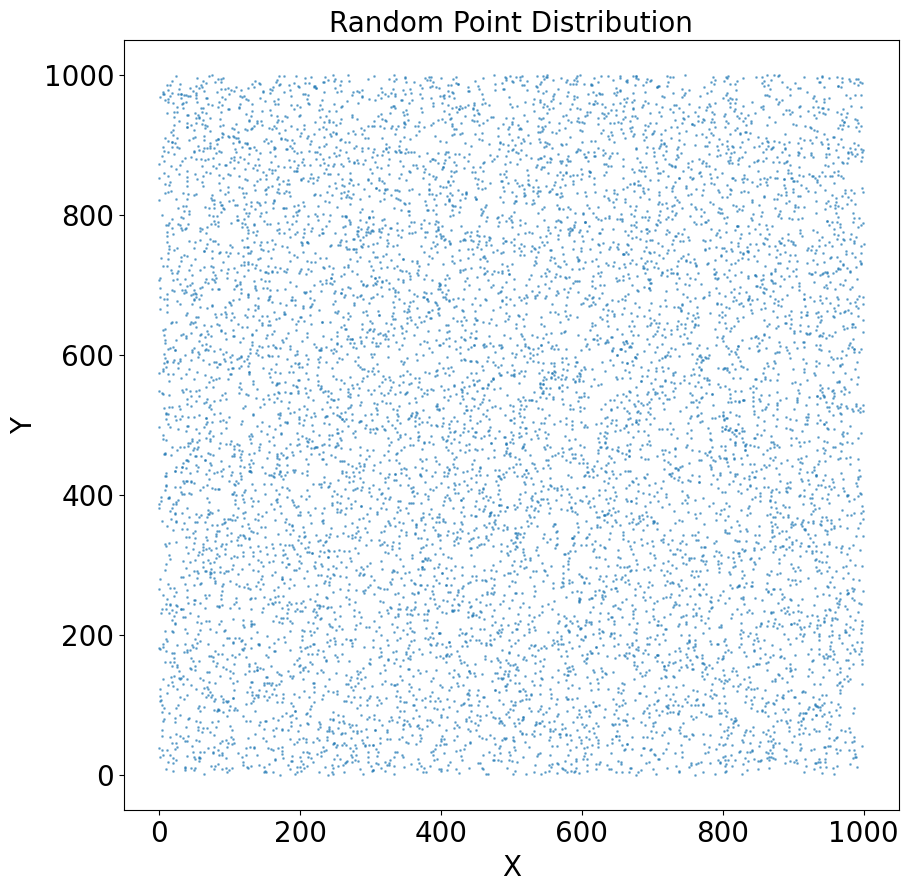

In [2]:
def generate_random_field(n_points, field_size=(1000, 1000)):
    """
    Generate n_points randomly distributed in a 2D field
    
    Parameters:
    -----------
    n_points : int
        Number of points to generate
    field_size : tuple
        Size of field in (x, y)
        
    Returns:
    --------
    points : array
        Array of shape (n_points, 2) containing point coordinates
    """
    x = np.random.uniform(0, field_size[0], n_points)
    y = np.random.uniform(0, field_size[1], n_points)
    return np.column_stack((x, y))

# Generate 10000 random points
points = generate_random_field(10000)

# Plot the points
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], s=1, alpha=0.5)
plt.title('Random Point Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Random Variables and Counting Statistics

The distinction between deterministic and random variables becomes particularly clear when we analyze stellar fields. Consider the average stellar density in any region of our simulated field. This quantity, determined by the underlying physical properties of the stellar distribution, represents a deterministic variable. However, the actual number of stars $N$ we observe in any given region is a random variable—it fluctuates around the expected value due to the stochastic nature of star positions.

This distinction parallels many astronomical measurements. Just as a planet's true orbital period is deterministic while our measurements of it contain random uncertainties, the true stellar density is fixed while our counts vary randomly. For counting observations, this randomness follows a specific mathematical form.

When counting discrete objects like stars, where each detection is independent and the average rate remains constant, the number of counts follows the Poisson distribution:

$$P(N = k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Here, $\lambda = \rho A$ represents the expected number of stars given the background density $\rho$ and the area $A$ of our counting region. The Poisson distribution emerges naturally when three conditions are met:
1. Events occur independently
2. The average rate is constant over the observation interval
3. Two events cannot occur at exactly the same location

To visualize this relationship between expected density and observed counts, we'll analyze the distribution of stars in circular annuli. By dividing our analysis regions into concentric rings, we can examine how counts vary at different radial distances while maintaining regions of equal area.

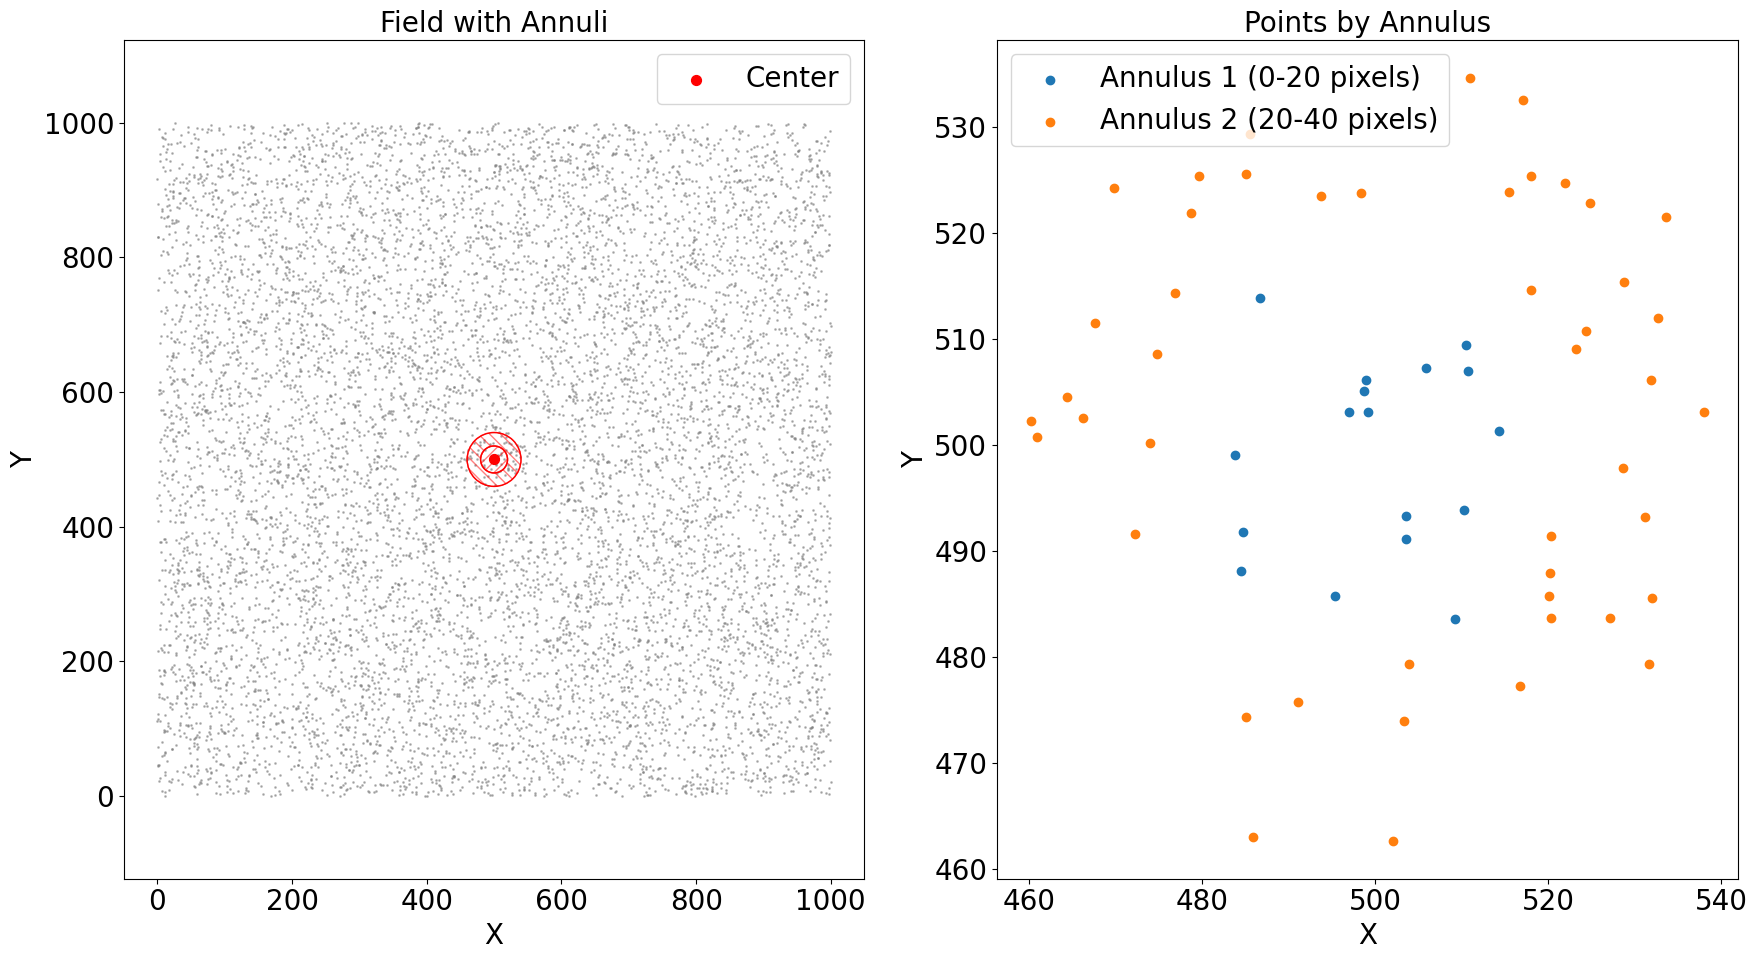

In [3]:
def plot_field_with_annuli(points, center):
    plt.figure(figsize=(18, 10))
    
    # Define radii for the annuli
    inner_radius = 0
    middle_radius = 20
    outer_radius = 40
    
    # Plot points and annuli
    plt.subplot(1, 2, 1)
    plt.scatter(points[:,0], points[:,1], s=1, alpha=0.5, color='gray')
    
    # First annulus (0-20)
    # Create patches for inner annulus with forward hatching
    wedge1 = matplotlib.patches.Wedge(center, middle_radius, 0, 360, 
                                    width=middle_radius-inner_radius,
                                    fill=False, hatch='///', 
                                    color='red', alpha=0.5)
    plt.gca().add_patch(wedge1)
    
    # Second annulus (20-40)
    # Create patches for outer annulus with backward hatching
    wedge2 = matplotlib.patches.Wedge(center, outer_radius, 0, 360,
                                    width=outer_radius-middle_radius,
                                    fill=False, hatch='\\\\\\',
                                    color='red', alpha=0.5)
    plt.gca().add_patch(wedge2)
    
    # Add circle boundaries
    for radius in [inner_radius, middle_radius, outer_radius]:
        circle = plt.Circle(center, radius, fill=False, color='red')
        plt.gca().add_artist(circle)
    
    plt.scatter(center[0], center[1], color='red', s=50, label='Center')
    plt.axis('equal')
    plt.title('Field with Annuli')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    distances = np.sqrt(np.sum((points - center)**2, axis=1))
    
    # First annulus: 0-20
    mask = (distances >= inner_radius) & (distances < middle_radius)
    points_in_annulus = points[mask]
    plt.scatter(points_in_annulus[:,0], points_in_annulus[:,1],
                label=f'Annulus 1 ({inner_radius}-{middle_radius} pixels)')
    
    # Second annulus: 20-40
    mask = (distances >= middle_radius) & (distances < outer_radius)
    points_in_annulus = points[mask]
    plt.scatter(points_in_annulus[:,0], points_in_annulus[:,1],
                label=f'Annulus 2 ({middle_radius}-{outer_radius} pixels)')
    
    plt.title('Points by Annulus')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate and plot field with annuli
points = generate_random_field(10000)
center = [500, 500]
plot_field_with_annuli(points, center)

This visualization illustrates how the random variable $N$ (number of stars) relates to the deterministic background density across different spatial regions. The annular geometry provides a natural framework for our analysis, as each annulus maintains constant area while sampling different radial distances from any given point.

For a uniform random field, the expected number of stars $\lambda$ in an annulus scales directly with its area. Given inner radius $r_1$ and outer radius $r_2$, the annular area is:

$$A = \pi(r_2^2 - r_1^2)$$

With uniform background density $\rho$ (points per unit area), the expected count becomes:

$$\lambda = \rho A = \rho\pi(r_2^2 - r_1^2)$$

Since we generated 10,000 points in a 1000 × 1000 pixel field, our background density is $\rho = 0.01$ points per pixel². This known density allows us to predict the expected counts in each annulus and verify that our observations follow the theoretical Poisson distribution.

To perform this verification rigorously, we'll use each point in our field as a potential center, calculating the neighbor counts within our defined annuli. This approach provides robust sampling statistics while naturally preparing us for cluster detection—points within clusters will show systematic deviations from the Poisson expectation in their neighbor counts.

In [4]:
def analyze_annulus_counts(counts, r_inner, r_outer, rho=0.01):
    """
    Analyze counts in an annulus and compare to expected Poisson distribution
    """
    # Calculate expected lambda from geometry
    area = np.pi * (r_outer**2 - r_inner**2)
    lambda_expected = rho * area
    lambda_observed = np.mean(counts)
    
    plt.figure(figsize=(10, 6))
    
    # Create integer bins that fully span our data
    bin_edges = np.arange(min(counts)-0.5, max(counts)+1.5, 1)
    
    # Plot histogram with these exact bins
    plt.hist(counts, bins=bin_edges, density=True, alpha=0.5,
            label='Observed counts', color='lightblue')
    
    # Create x values for Poisson PMF at exact integers
    x = np.arange(min(counts), max(counts)+1)
    poisson = stats.poisson.pmf(x, lambda_observed)
    
    # Plot Poisson PMF at these exact values
    plt.plot(x, poisson, 'r-', linewidth=2, 
            label=f'Poisson(λ={lambda_observed:.1f})')
    
    plt.title(f'Counts in Annulus {r_inner:.1f}-{r_outer:.1f}')
    plt.xlabel('Number of Points')
    plt.ylabel('Probability')
    plt.legend()
    
    # Set x-axis to show fewer ticks
    plt.xticks(np.arange(min(counts), max(counts)+1, 5))  # Show every 5th tick
    
    plt.show()
    
    print(f"Expected λ from area: {lambda_expected:.2f}")
    print(f"Observed mean count: {lambda_observed:.2f}")
    print(f"Observed variance: {np.var(counts):.2f}")

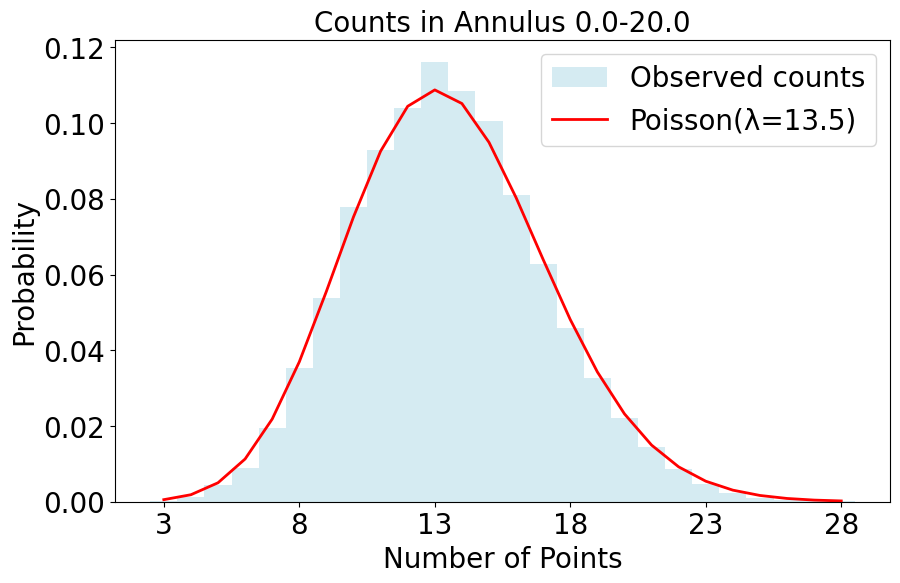

Expected λ from area: 12.57
Observed mean count: 13.54
Observed variance: 12.56


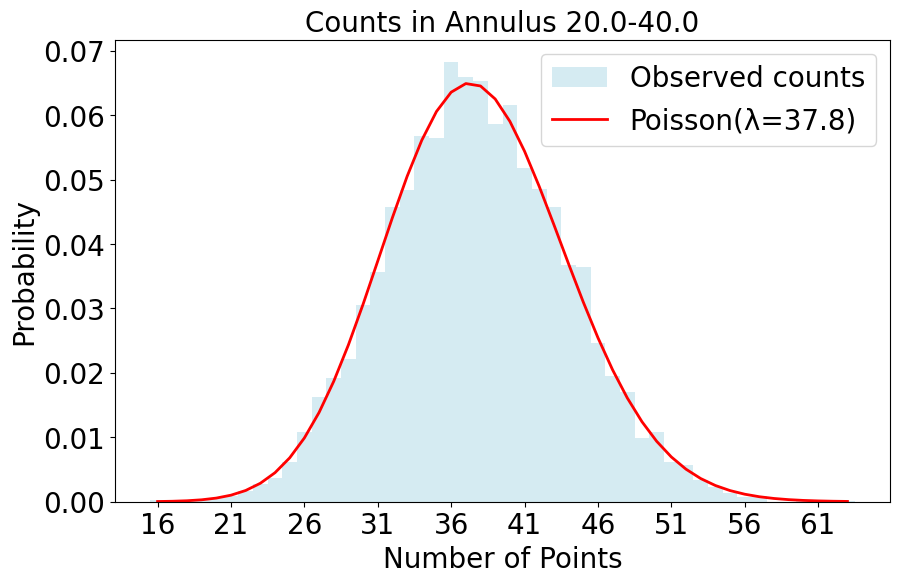

Expected λ from area: 37.70
Observed mean count: 37.78
Observed variance: 37.03


In [5]:
# Define radii
radii = np.array([0, 20, 40]) 

# Calculate counts for each point as center
all_counts = []

# Calculate all pairwise distances with periodic boundary conditions
field_size = 1000  # Size of the field
distances = np.zeros((len(points), len(points)))
for i in range(len(points)):
    dx = points[:, 0] - points[i, 0]
    dy = points[:, 1] - points[i, 1]
    
    # Apply periodic boundary conditions
    dx = np.where(dx > field_size/2, dx - field_size, dx)
    dx = np.where(dx < -field_size/2, dx + field_size, dx)
    dy = np.where(dy > field_size/2, dy - field_size, dy)
    dy = np.where(dy < -field_size/2, dy + field_size, dy)
    
    distances[i] = np.sqrt(dx**2 + dy**2)

for i in range(len(points)):
    counts = np.zeros(len(radii)-1)  # Store counts for each annulus
    
    for j in range(len(radii)-1):
        r_inner = radii[j]
        r_outer = radii[j+1]
        mask = (distances[i] >= r_inner) & (distances[i] < r_outer)
        counts[j] = np.sum(mask)
    
    all_counts.append(counts)

# Convert to numpy array for easier analysis
all_counts = np.array(all_counts)

# Analyze counts in all three annuli
for i in range(2):
    analyze_annulus_counts(all_counts[:,i], radii[i], radii[i+1])

The implementation above employs several important techniques that merit discussion. First, we use every point in our field as a potential center for counting neighbors. This approach dramatically improves our sampling statistics compared to analyzing just a single center, giving us 10,000 independent measurements of the local density distribution. This extensive sampling is crucial for accurately characterizing the underlying Poisson distribution and will later enable us to identify individual points that deviate significantly from expectations.

We also implement periodic boundary conditions, effectively treating our field as a torus. Without these conditions, points near the field edges would systematically show fewer neighbors than interior points, introducing an artificial bias in our density measurements. By wrapping distances across boundaries—connecting the left edge to the right edge and top to bottom—we ensure that every point experiences a complete neighborhood, maintaining true spatial homogeneity.

This periodic treatment is particularly elegant mathematically. When the x-distance between two points exceeds half the field size, we know the shorter path wraps around the boundary. The same logic applies to y-distances. While we use periodic boundaries here for computational convenience, real astronomical applications would typically exclude edge regions from analysis or apply appropriate window functions to account for boundary effects.

The resulting distributions confirm our theoretical expectations beautifully. Each annulus shows count distributions that closely match the Poisson distribution with $\lambda$ equal to the observed mean. The agreement between observed and expected $\lambda$ values validates both our uniform field generation and our understanding of how Poisson processes manifest in spatial point patterns. This sets the stage for exploring more complex statistical relationships between different spatial regions.

## Joint and Conditional Distributions in Point Counts

The distributions we examined for individual annuli represent marginal distributions—they tell us about counts in single regions without considering relationships between regions. Specifically, $P(N_i)$ gives the probability of observing $N_i$ points in annulus $i$, marginalized over all possible configurations in other annuli:

$$P(N_i) = \sum_j P(N_i,N_j)$$

where $P(N_i,N_j)$ denotes the joint probability of simultaneously observing $N_i$ points in annulus $i$ and $N_j$ points in annulus $j$.

Understanding these joint distributions is crucial for cluster detection. While marginal distributions characterize the overall density field, joint distributions reveal spatial correlations. In a truly random field, we expect no correlation between counts in non-overlapping regions. However, the presence of a cluster would induce positive correlations—high counts in one annulus would predict high counts in nearby annuli.

The joint distribution $P(N_1,N_2)$ between our two annuli captures this relationship. We can estimate it empirically by creating a two-dimensional histogram of our observed count pairs. Each point in our field contributes one $(N_1, N_2)$ pair, where $N_1$ represents neighbors in the inner annulus (0-20 pixels) and $N_2$ represents neighbors in the outer annulus (20-40 pixels).

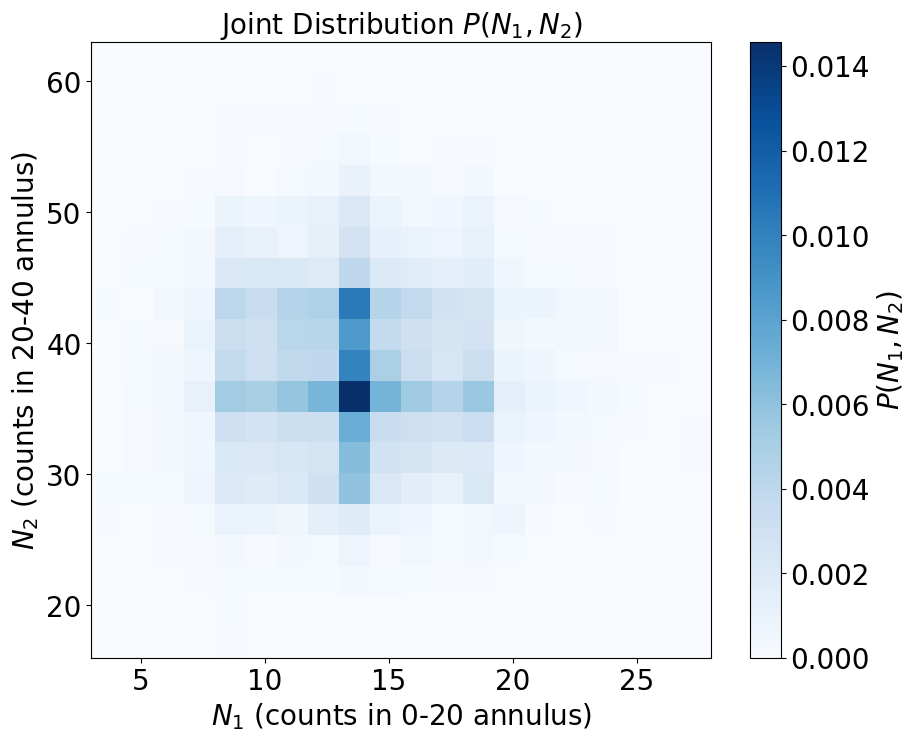

In [6]:
def plot_joint_distribution(all_counts):
    """
    Plot joint distribution between first two annuli
    """
    plt.figure(figsize=(10, 8))
    
    # Create 2D histogram
    h = plt.hist2d(all_counts[:,0], all_counts[:,1], bins=20, density=True, cmap='Blues')
    plt.colorbar(h[3], label='$P(N_1,N_2)$')
    
    plt.xlabel('$N_1$ (counts in 0-20 annulus)')
    plt.ylabel('$N_2$ (counts in 20-40 annulus)')
    plt.title('Joint Distribution $P(N_1,N_2)$')
    plt.show()

plot_joint_distribution(all_counts)

The joint distribution reveals the relationship between counts in our two annuli. For a truly random point process, we expect this distribution to show no significant correlation structure—the counts in one annulus should not predict counts in the other.

To examine this independence more carefully, we can analyze the conditional distribution $P(N_2|N_1)$, which represents the probability distribution of counts in the outer annulus given a specific count in the inner annulus. If the annuli are statistically independent, then:

$$P(N_2|N_1) = P(N_2)$$

This equality states that knowing $N_1$ provides no information about $N_2$. We can test this empirically by selecting subsets of our data with specific $N_1$ values and examining the resulting $N_2$ distributions. Since we're dealing with discrete Poisson counts, we can choose exact integer values of $N_1$ and analyze the corresponding conditional distributions.

From the product rule of probability, we know:

$$P(N_1,N_2) = P(N_2|N_1)P(N_1)$$

When independence holds, this simplifies to:

$$P(N_1,N_2) = P(N_2)P(N_1)$$

This factorization has profound practical implications. It means we can analyze each annulus separately without losing information about their joint behavior. This dimensionality reduction is particularly valuable when extending our analysis to multiple annuli or when working with limited data where estimating high-dimensional joint distributions becomes challenging.


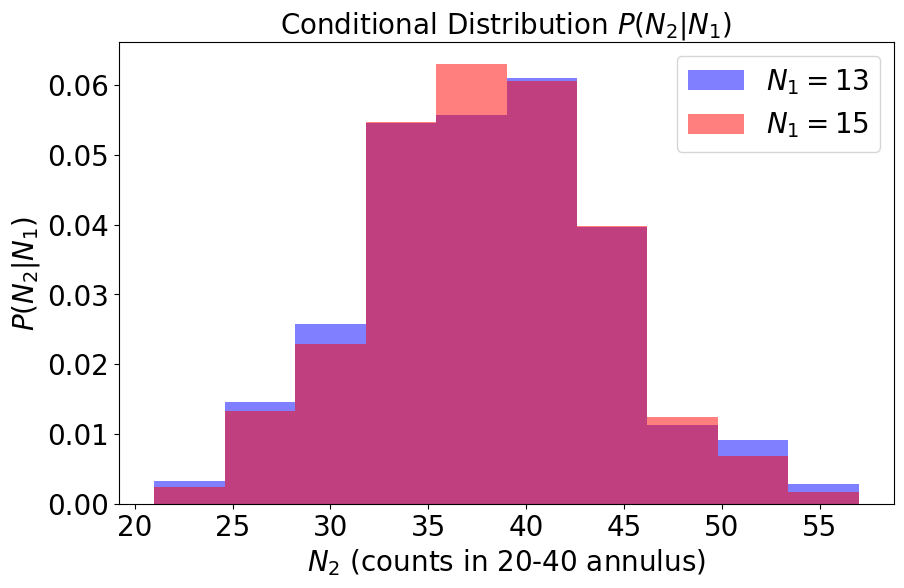

In [7]:
def plot_conditional_distribution(all_counts):
    """
    Plot conditional distribution of N₂ for different N₁ values
    """
    # Choose two specific N₁ values to examine
    N1_values = [13, 15]  # Two specific N₁ values to condition on
    
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'red']
    
    for N1, color in zip(N1_values, colors):
        # Select points where N₁ exactly matches our chosen value
        matches = all_counts[all_counts[:,0] == N1]
        plt.hist(matches[:,1], bins=10, density=True, alpha=0.5,
                label=f'$N_1 = {N1}$', color=color)
    
    plt.xlabel('$N_2$ (counts in 20-40 annulus)')
    plt.ylabel('$P(N_2|N_1)$')
    plt.title('Conditional Distribution $P(N_2|N_1)$')
    plt.legend()
    plt.show()

plot_conditional_distribution(all_counts)

The similarity between the conditional distributions $P(N_2|N_1=13)$ and $P(N_2|N_1=15)$ provides empirical evidence for statistical independence. Despite conditioning on different $N_1$ values, the distributions of $N_2$ remain essentially unchanged. This behavior is expected for a truly random point process—the number of points in one annulus provides no predictive power for the number in a non-overlapping annulus.

This independence property is fundamental to our cluster detection strategy. In a random field, high neighbor counts around a point are simply statistical fluctuations that don't extend to larger radii. In contrast, a genuine cluster would create correlated high counts across multiple annuli centered on the same point. By quantifying deviations from independence, we can distinguish between random fluctuations and true physical overdensities.

The mathematical framework of independence also provides computational advantages. When analyzing multiple annuli, the joint probability distribution over all annuli becomes high-dimensional and difficult to estimate from finite data. However, if independence holds, we can factor this complex joint distribution into a product of simple marginal distributions:

$$P(N_1, N_2, ..., N_k) = P(N_1)P(N_2)...P(N_k)$$

This factorization reduces the number of parameters we need to estimate from exponential in $k$ to linear in $k$, making the analysis tractable even for many annuli. Of course, this simplification only applies to our null hypothesis of a random field—detecting clusters requires identifying where this independence assumption breaks down.

## Detecting Clusters Through Likelihood Analysis

Having established that our background field follows Poisson statistics with independent counts in non-overlapping regions, we can now develop a framework for cluster detection. The key insight is that stellar clusters manifest as regions where the local neighbor count $N$ significantly exceeds the Poisson expectation for a random field.

For each star in our field, we can count the number of neighbors within a specified radius and compare this to our null hypothesis—the expected distribution in a random field. Points belonging to clusters will show systematically higher neighbor counts, making them statistically distinguishable from the background population.

To test our detection methodology, we'll inject artificial clusters into our random field. We model each cluster as a two-dimensional Gaussian distribution of points, chosen for its mathematical simplicity and reasonable approximation to many real stellar clusters. The cluster centers are placed uniformly at random within our field, and each member star's position follows:

$$(x,y) \sim \mathcal{N}((x_c,y_c), \sigma^2I_2)$$

where $(x_c, y_c)$ is the cluster center and $\sigma$ controls the cluster's spatial extent. We choose $\sigma \approx 20$ pixels to roughly match our analysis scale, ensuring optimal sensitivity for detection.

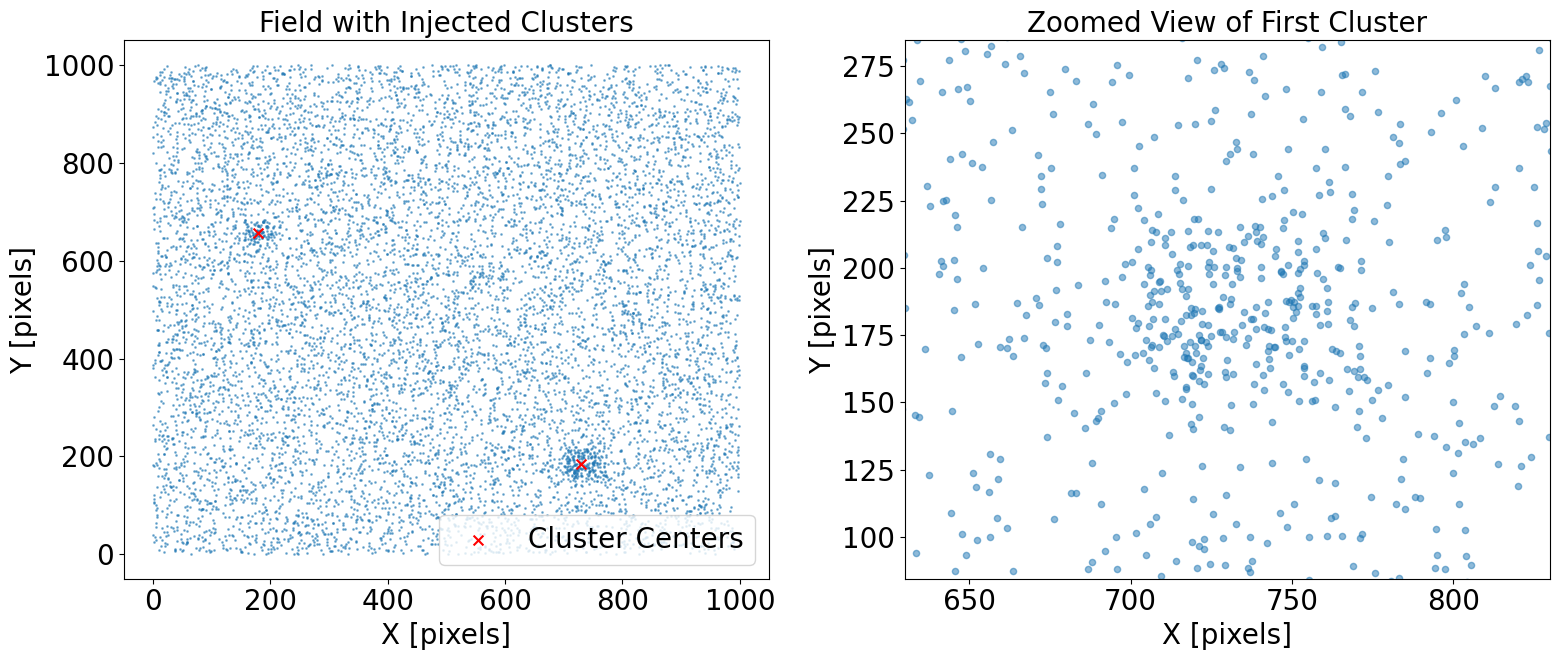

First cluster: 200 points at (730.0, 184.5)
Second cluster: 100 points at (179.0, 657.2)


In [8]:
def generate_cluster(n_points, center, sigma):
   """
   Generate a cluster of points with 2D Gaussian distribution
   
   Parameters:
   -----------
   n_points : int
       Number of points in cluster
   center : array-like
       (x,y) coordinates of cluster center 
   sigma : float
       Standard deviation of Gaussian distribution
       
   Returns:
   --------
   points : array
       Array of shape (n_points, 2) containing cluster point coordinates
   """
   # Generate points from 2D Gaussian
   x = np.random.normal(center[0], sigma, n_points)
   y = np.random.normal(center[1], sigma, n_points)
   
   return np.column_stack((x, y))

# Set random seed for reproducibility  
np.random.seed(42)

# Field parameters
L = 1000  # Field size in pixels

# Generate background points
background_points = generate_random_field(10000)

# Generate clusters
# First cluster: 50 points, sigma=20
center1 = np.random.uniform(0, L, 2)  # Random center
cluster1 = generate_cluster(200, center1, 20)

# Second cluster: 100 points, sigma=15 
center2 = np.random.uniform(0, L, 2)  # Random center
cluster2 = generate_cluster(100, center2, 15)

# Combine background and clusters
field_with_clusters = np.vstack((background_points, cluster1, cluster2))

# Plot the field
plt.figure(figsize=(16, 7))

# Plot full field
plt.subplot(1, 2, 1)
plt.scatter(field_with_clusters[:,0], field_with_clusters[:,1], 
           s=1, alpha=0.5)
plt.title('Field with Injected Clusters')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')

# Plot zoomed view of first cluster
plt.subplot(1, 2, 2)
margin = 100
plt.scatter(field_with_clusters[:,0], field_with_clusters[:,1], 
           s=20, alpha=0.5)
plt.xlim(center1[0]-margin, center1[0]+margin)
plt.ylim(center1[1]-margin, center1[1]+margin)
plt.title('Zoomed View of First Cluster')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')

# Add cluster centers
plt.subplot(1, 2, 1)
plt.scatter([center1[0], center2[0]], [center1[1], center2[1]], 
           color='red', marker='x', s=50, label='Cluster Centers')
plt.legend()

plt.tight_layout()
plt.show()

# Print cluster parameters
print(f"First cluster: {len(cluster1)} points at ({center1[0]:.1f}, {center1[1]:.1f})")
print(f"Second cluster: {len(cluster2)} points at ({center2[0]:.1f}, {center2[1]:.1f})")

## Likelihood Analysis

With clusters now embedded in our field, we can develop a statistical framework to detect them. For each point in our field, we count the number of neighbors $N$ within a specified radius. Under our null hypothesis of a random field, this count should follow the Poisson distribution:

$$P(N|\lambda) = \frac{\lambda^N e^{-\lambda}}{N!}$$

This probability $P(N|\lambda)$ represents the likelihood of observing exactly $N$ neighbors given our background model with expected count $\lambda$. The likelihood quantifies how probable our observation is under the assumed model—low likelihood values indicate that our observation is unlikely given the model assumptions.

Points belonging to clusters will have abnormally high neighbor counts, resulting in very low likelihoods under the background-only model. This makes intuitive sense: finding many neighbors around a point is highly improbable if stars were truly distributed at random. The key insight is that genuine physical structures (clusters) produce neighbor counts that are statistically incompatible with random placement.

The log-likelihood provides a more convenient metric for analysis:

$$\log L = N\log(\lambda) - \lambda - \log(N!)$$

Taking the logarithm offers several advantages. It prevents numerical underflow when dealing with very small probabilities, converts products of probabilities into sums, and provides a quantity that scales linearly with the extremeness of the observation. More negative log-likelihood values indicate increasingly improbable observations under our null hypothesis.

By calculating the log-likelihood across our entire field, we can create spatial maps that highlight regions of anomalously high density. Clusters appear as "wells" in the likelihood landscape—regions where the observed counts are so high that they would be extremely unlikely to occur by chance in a random field.


In [9]:
# Calculate all pairwise distances with periodic boundary conditions for new field
field_size = 1000  # Size of the field
distances = np.zeros((len(field_with_clusters), len(field_with_clusters)))
for i in range(len(field_with_clusters)):
    dx = field_with_clusters[:, 0] - field_with_clusters[i, 0]
    dy = field_with_clusters[:, 1] - field_with_clusters[i, 1]
    
    # Apply periodic boundary conditions
    dx = np.where(dx > field_size/2, dx - field_size, dx)
    dx = np.where(dx < -field_size/2, dx + field_size, dx)
    dy = np.where(dy > field_size/2, dy - field_size, dy)
    dy = np.where(dy < -field_size/2, dy + field_size, dy)
    
    distances[i] = np.sqrt(dx**2 + dy**2)

# Define radii for N₁
radii = np.array([0, 20, 40])

# Calculate counts for each point as center
all_counts = []

for i in range(len(field_with_clusters)):
    counts = np.zeros(len(radii)-1)  # Store counts for each annulus
    
    for j in range(len(radii)-1):
        r_inner = radii[j]
        r_outer = radii[j+1]
        mask = (distances[i] >= r_inner) & (distances[i] < r_outer)
        counts[j] = np.sum(mask)
    
    all_counts.append(counts)

all_counts = np.array(all_counts)

# Separate N₁ counts for background and clusters
background_N1 = all_counts[:10000, 0]  # First 10000 points are background
cluster1_N1 = all_counts[10000:10200, 0]  # Next 200 points are cluster 1
cluster2_N1 = all_counts[10200:, 0]  # Last 200 points are cluster 2

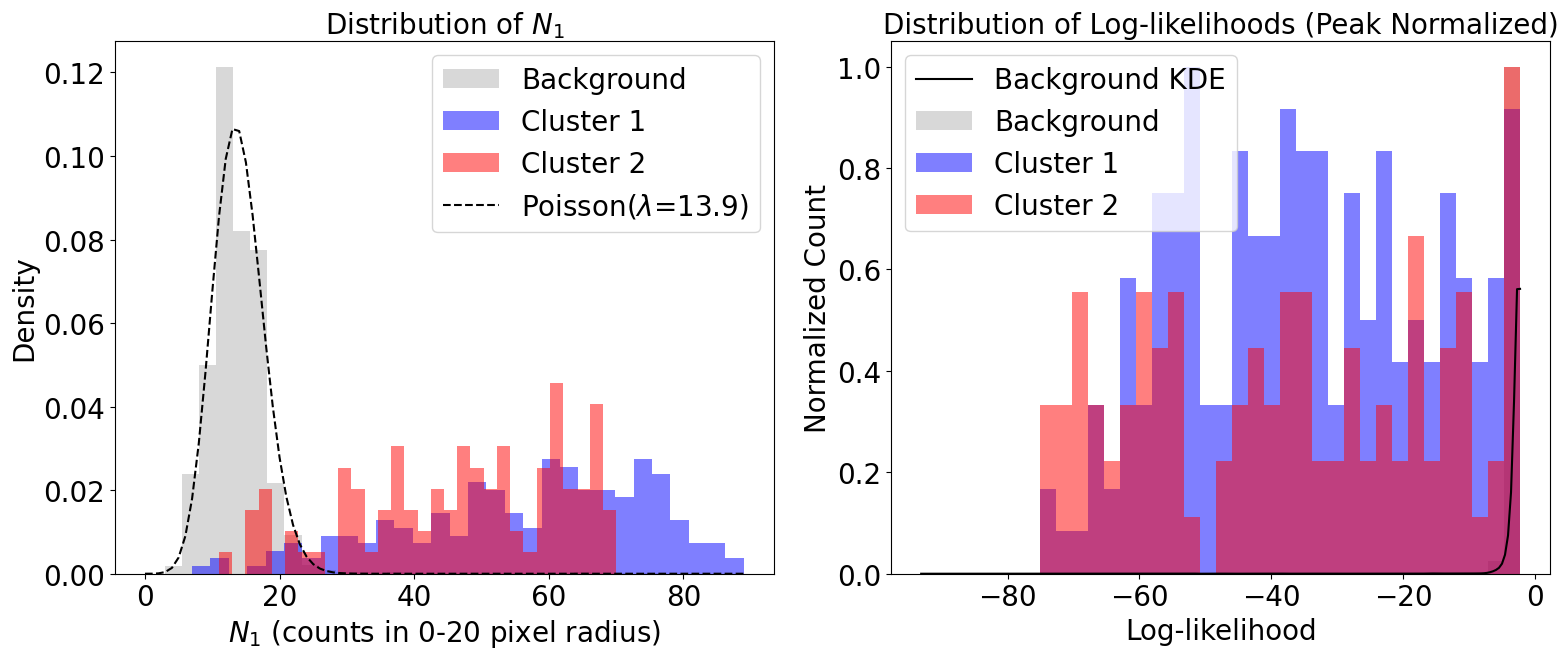

Mean $N_1$ counts:
Background: 13.9
Cluster 1: 56.6
Cluster 2: 47.2

Expected from density: 13.9


In [10]:
# Plot distribution comparison
plt.figure(figsize=(16, 7))

# Plot 1: Histogram comparison with KDE for background
plt.subplot(1, 2, 1)
plt.hist(background_N1, bins=30, density=True, alpha=0.3,
         label='Background', color='gray')
plt.hist(cluster1_N1, bins=30, density=True, alpha=0.5,
         label='Cluster 1', color='blue')
plt.hist(cluster2_N1, bins=30, density=True, alpha=0.5,
         label='Cluster 2', color='red')

# Add theoretical Poisson distribution
x = np.arange(0, max(all_counts[:,0])+1)
lambda_expected = np.mean(background_N1)
poisson = stats.poisson.pmf(x, lambda_expected)
plt.plot(x, poisson, 'k--', label=f'Poisson($\\lambda$={lambda_expected:.1f})')

plt.xlabel('$N_1$ (counts in 0-20 pixel radius)')
plt.ylabel('Density')
plt.title('Distribution of $N_1$')
plt.legend()

# Plot 2: Log-likelihood comparison
plt.subplot(1, 2, 2)
log_likelihoods = stats.poisson.logpmf(all_counts[:,0], lambda_expected)

# Calculate histograms
hist_bg, bins_bg = np.histogram(log_likelihoods[:10000], bins=30)
hist_c1, bins_c1 = np.histogram(log_likelihoods[10000:10200], bins=30)
hist_c2, _ = np.histogram(log_likelihoods[10200:], bins=30)

# Normalize each histogram by its peak value
hist_bg_norm = hist_bg / np.max(hist_bg)
hist_c1_norm = hist_c1 / np.max(hist_c1)
hist_c2_norm = hist_c2 / np.max(hist_c2)

# Plot normalized histograms
bin_centers = (bins_bg[:-1] + bins_bg[1:]) / 2
plt.bar(bin_centers, hist_bg_norm, width=np.diff(bins_bg)[0], alpha=0.3,
        label='Background', color='gray')
plt.bar(bin_centers, hist_c1_norm, width=np.diff(bins_bg)[0], alpha=0.5,
        label='Cluster 1', color='blue')
plt.bar(bin_centers, hist_c2_norm, width=np.diff(bins_bg)[0], alpha=0.5,
        label='Cluster 2', color='red')

# Add KDE for background
kde_bg = stats.gaussian_kde(log_likelihoods[:10000])
x_kde = np.linspace(min(log_likelihoods), max(log_likelihoods), 200)
plt.plot(x_kde, kde_bg(x_kde), 'k-', label='Background KDE')

plt.xlabel('Log-likelihood')
plt.ylabel('Normalized Count')
plt.title('Distribution of Log-likelihoods (Peak Normalized)')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Mean $N_1$ counts:")
print(f"Background: {np.mean(background_N1):.1f}")
print(f"Cluster 1: {np.mean(cluster1_N1):.1f}")
print(f"Cluster 2: {np.mean(cluster2_N1):.1f}")
print(f"\nExpected from density: {lambda_expected:.1f}")

The comparison reveals striking differences between background and cluster populations. In the left panel, we see that background points (gray) closely follow the expected Poisson distribution with $\lambda \approx 14$, validating our random field model. Points within clusters (blue and red) show dramatically higher neighbor counts, typically 40-80 neighbors compared to the background's 10-20. This enhancement reflects the increased local density within clusters.

The right panel shows the log-likelihood distributions, where we employ Kernel Density Estimation (KDE) to better visualize the underlying probability density. When analyzing discrete count data, histograms can appear spiky due to the concentration of values at specific integers. KDE smooths these discrete observations into a continuous probability density function, revealing the overall distribution shape more clearly. This technique proves particularly valuable when comparing populations with different sample sizes, as it normalizes for the number of observations.

The clear separation in log-likelihood values between background and cluster populations demonstrates the power of likelihood-based detection. Cluster members consistently show log-likelihoods below -10, while background points cluster around -3 to -5. This separation suggests we can construct an effective detection algorithm by identifying regions where the local density produces anomalously low likelihoods under our background model.

To visualize this detection capability, we can create a spatial map of log-likelihoods across our field. By evaluating the likelihood at a grid of positions, we transform our point data into a continuous detection surface where clusters appear as regions of extremely low likelihood:

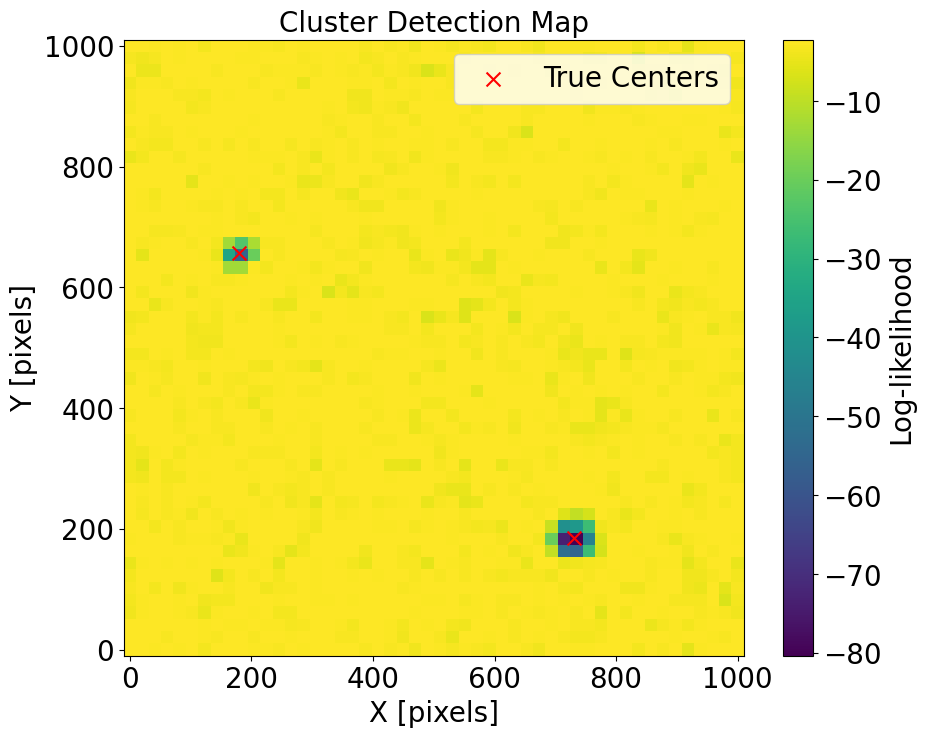

In [11]:
def calculate_likelihood_map(field, grid_size=50, radius=20, lambda_bg=lambda_expected):
    """
    Calculate log-likelihood map for cluster detection
    """
    # Create grid of positions
    x = np.linspace(0, field_size, grid_size)
    y = np.linspace(0, field_size, grid_size)
    X, Y = np.meshgrid(x, y)
    likelihood = np.zeros((grid_size, grid_size))
    
    # Calculate N₁ and its log-likelihood at each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate distances from current position to all points
            dx = field[:, 0] - X[i,j]
            dy = field[:, 1] - Y[i,j]
            
            # Apply periodic boundary conditions
            dx = np.where(dx > field_size/2, dx - field_size, dx)
            dx = np.where(dx < -field_size/2, dx + field_size, dx)
            dy = np.where(dy > field_size/2, dy - field_size, dy)
            dy = np.where(dy < -field_size/2, dy + field_size, dy)
            
            # Count points within radius
            distances = np.sqrt(dx**2 + dy**2)
            N1 = np.sum(distances < radius)
            
            # Calculate log-likelihood
            likelihood[i,j] = stats.poisson.logpmf(N1, lambda_bg)
    
    return X, Y, likelihood

# Calculate likelihood map
X, Y, likelihood = calculate_likelihood_map(field_with_clusters)

# Plot the map
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, likelihood, cmap='viridis')
plt.colorbar(label='Log-likelihood')
plt.scatter([center1[0], center2[0]], [center1[1], center2[1]], 
            color='red', marker='x', s=100, label='True Centers')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.title('Cluster Detection Map')
plt.legend()
plt.show()

The likelihood map elegantly reveals both injected clusters as regions of extremely low likelihood (dark regions in the viridis colormap). The detection is remarkably clean—the cluster locations stand out as clear minima in the likelihood landscape, with values dropping well below -20 compared to the background range of approximately -3 to -5. This dramatic contrast demonstrates the statistical power of the Poisson likelihood for detecting overdensities.

## Methodological Considerations

Our analysis thus far has relied on two key simplifying assumptions that merit careful examination:

**Strategic Choice of Analysis Scale**

We selected a 20-pixel radius for our neighbor counts, matching the characteristic size of our injected clusters. This prior knowledge enabled optimal detection sensitivity. In practice, cluster sizes are rarely known in advance, necessitating a multi-scale approach. The use of annuli rather than circles becomes particularly valuable here:

- Annuli at different radii remain statistically independent for random fields, enabling separate analysis at each scale
- Nested circles would introduce strong correlations, as larger radii include all points from smaller radii
- Real surveys often employ a hierarchy of annuli to search for clusters across a range of physical scales

The astronomical application that inspired this tutorial ([Greene et al. 2021](https://arxiv.org/abs/2105.04581)) exemplifies this multi-scale approach, searching for stellar overdensities that could indicate intermediate-mass black holes by testing multiple characteristic scales.

**Poisson Distribution for Background Modeling**

Our adoption of the Poisson distribution for background counts offers several analytical advantages:

- The single parameter $\lambda$ has clear physical meaning as the average count rate
- The distribution naturally models discrete counting data
- For uniform fields, we can estimate $\lambda$ directly from the observed mean

However, real astronomical fields often show more complex statistics. The negative binomial distribution frequently provides a better description of stellar counts, accounting for clustering in the background population itself. Understanding when the simple Poisson model suffices and when more sophisticated distributions are needed requires careful analysis of the specific astronomical context.

## Maximum Likelihood Estimation

Our likelihood analysis thus far has assumed we know the true background parameter $\lambda$. In practice, we must estimate this parameter from the data itself. Maximum Likelihood Estimation (MLE) provides a principled framework for finding the parameter value that best explains our observations.

The joint likelihood represents the probability of observing all our data points simultaneously. For independent observations $\{x_1, x_2, ..., x_n\}$ from a Poisson distribution, this joint likelihood is:

$$\mathcal{L}(\lambda|x_1,...,x_n) = \prod_{i=1}^n \frac{\lambda^{x_i} e^{-\lambda}}{x_i!}$$

Each factor represents the probability of observing count $x_i$ given parameter $\lambda$. The product arises because we require all these observations to occur—the joint probability of independent events is the product of their individual probabilities.

Taking the logarithm transforms this product into a sum, yielding the log-likelihood:

$$\log \mathcal{L}(\lambda|x_1,...,x_n) = \sum_{i=1}^n (x_i \log(\lambda) - \lambda - \log(x_i!))$$

The maximum likelihood estimate $\hat{\lambda}$ is the value that maximizes this function. For the Poisson distribution, we can derive this analytically by setting the derivative equal to zero, yielding $\hat{\lambda} = \bar{x}$, the sample mean. However, we'll demonstrate a numerical approach that generalizes to more complex scenarios where analytical solutions may not exist.

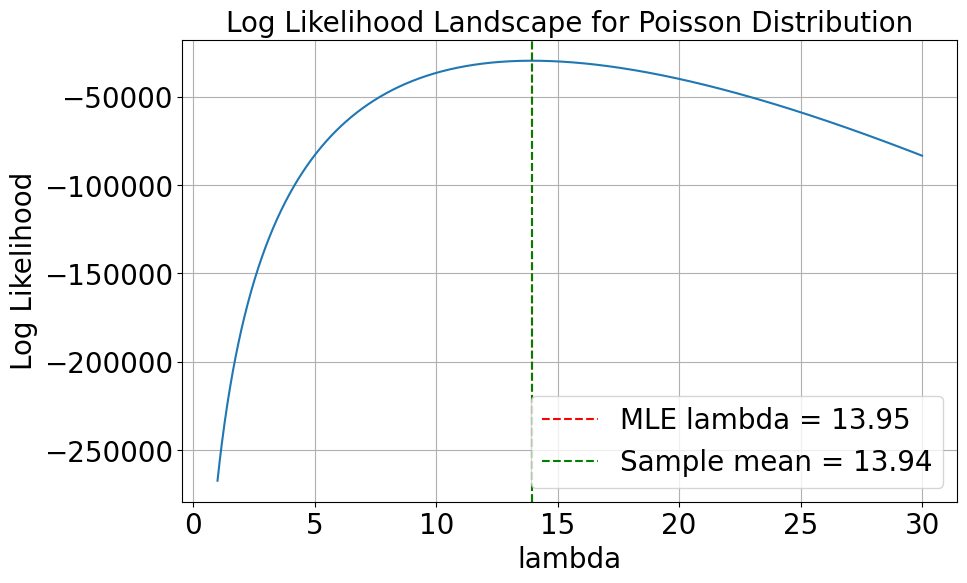

MLE estimate of lambda: 13.947
Sample mean: 13.938


In [12]:
# Function to compute log likelihood for Poisson distribution
def poisson_log_likelihood(lambda_param, counts):
    """
    Compute log likelihood for Poisson distribution
    
    Parameters:
    -----------
    lambda_param : float
        Rate parameter of Poisson distribution (lambda)
    counts : array
        Array of observed counts
        
    Returns:
    --------
    float
        Log likelihood value
    """
    return np.sum(stats.poisson.logpmf(counts, lambda_param))

# Get counts from background - assuming counts is 1D array
counts_background = background_N1

# Define grid of lambda values to search
lambda_grid = np.linspace(1, 30, 1000)
log_likelihoods = []

# Compute log likelihood for each lambda value
for lambda_val in lambda_grid:
    ll = poisson_log_likelihood(lambda_val, counts_background)
    log_likelihoods.append(ll)
    
# Find optimal lambda
best_lambda = lambda_grid[np.argmax(log_likelihoods)]

# Plot likelihood landscape
plt.figure(figsize=(10,6))
plt.plot(lambda_grid, log_likelihoods)
plt.axvline(best_lambda, color='r', linestyle='--', 
            label=f'MLE lambda = {best_lambda:.2f}')
plt.axvline(np.mean(counts_background), color='g', linestyle='--',
            label=f'Sample mean = {np.mean(counts_background):.2f}')
plt.xlabel('lambda')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood Landscape for Poisson Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Print optimal lambda and compare to sample mean
print(f"MLE estimate of lambda: {best_lambda:.3f}")
print(f"Sample mean: {np.mean(counts_background):.3f}")

The likelihood landscape reveals a well-defined maximum that coincides precisely with the sample mean, confirming the theoretical result that the MLE for a Poisson distribution equals the arithmetic mean of the observations. This agreement validates both our numerical approach and the appropriateness of the Poisson model for our background field.

The grid search method, while computationally straightforward, illustrates the general principle of maximum likelihood estimation. We evaluate the likelihood function across a range of parameter values and select the one that maximizes the probability of observing our data. For more complex distributions or multi-parameter models, this brute-force approach becomes computationally prohibitive, motivating gradient-based optimization methods that we'll explore in subsequent chapters.

From a Bayesian perspective, our MLE approach implicitly assumes a uniform prior over $\lambda$—we consider all parameter values equally plausible before observing the data. This uninformative prior represents a conservative choice when we lack prior knowledge about the expected background density. In scenarios where we have physical constraints or previous observations, incorporating informative priors through Bayesian inference can improve our parameter estimates, particularly with limited data.

## Summary

This tutorial has demonstrated how probability theory provides powerful tools for detecting structure in spatial point patterns. Through the lens of stellar cluster detection, we've explored fundamental concepts that extend far beyond this specific application:

1. **Statistical Modeling**: We developed a null hypothesis based on the Poisson distribution, characterizing the expected behavior of randomly distributed points.

2. **Hypothesis Testing**: By comparing observed neighbor counts to theoretical expectations, we constructed a likelihood-based framework for identifying statistically significant overdensities.

3. **Parameter Estimation**: Maximum likelihood estimation allowed us to infer the background density directly from our data, providing a data-driven characterization of the field.

4. **Spatial Statistics**: Our analysis of annular regions demonstrated how to handle two-dimensional point patterns while maintaining statistical independence between measurements.

The techniques developed here form the foundation for numerous astronomical applications, from detecting galaxy clusters in redshift surveys to identifying exoplanet transits in photometric time series. The key insight remains constant: by quantifying what we expect under a null hypothesis, we can rigorously identify departures that signal genuine physical phenomena.
